In [1]:
DEVICE = 'cuda:3'

In [2]:
import torch
import transformers

from tqdm import tqdm
import numpy as np

In [3]:
import os

def load_txt_files_to_dict(directory, filetype=".txt"):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(filetype):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

def load_txt_files_to_dict__flores(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
            # Flores' files with text do not have the extension. The language is indicated after the dot symbol
            text_dict[os.path.splitext(filename)[1][1:]] = text.split("\n")
    return text_dict

In [4]:
!git clone https://github.com/averkij/woland.git

fatal: destination path 'woland' already exists and is not an empty directory.


In [5]:
# # Reading Flores debug
# name1 = "dev.ace_Arab"
# data_dir = "floresp-v2.0-rc.3/dev"

# file_path = os.path.join(data_dir, name1)
# with open(file_path, "r", encoding="utf-8") as file:
#     text = file.read()

In [6]:
# dataset 

# woland_directory = "woland/text"
# dataset_texts = load_txt_files_to_dict(data_dir)

data_dir = "floresp-v2.0-rc.3/dev"
dataset_texts = load_txt_files_to_dict__flores(data_dir)

In [7]:
dataset_texts.keys()

dict_keys(['yor_Latn', 'isl_Latn', 'ces_Latn', 'ban_Latn', 'kmr_Latn', 'kik_Latn', 'guj_Gujr', 'gle_Latn', 'hin_Deva', 'mal_Mlym', 'ukr_Cyrl', 'azb_Arab', 'mai_Deva', 'pes_Arab', 'chv_Cyrl', 'kea_Latn', 'fao_Latn', 'kab_Latn', 'cjk_Latn', 'lit_Latn', 'ell_Grek', 'nus_Latn', 'nno_Latn', 'lij_Latn', 'mar_Deva', 'san_Deva', 'dik_Latn', 'ewe_Latn', 'arz_Arab', 'bak_Cyrl', 'min_Arab', 'vie_Latn', 'kat_Geor', 'arb_Latn', 'hye_Armn', 'tur_Latn', 'ind_Latn', 'bho_Deva', 'ory_Orya', 'shn_Mymr', 'rus_Cyrl', 'spa_Latn', 'cym_Latn', 'snd_Arab', 'gla_Latn', 'swh_Latn', 'fuv_Latn', 'apc_Arab_nort3139', 'ron_Latn', 'ltz_Latn', 'acq_Arab', 'zgh_Tfng', 'sag_Latn', 'ary_Arab', 'uig_Arab', 'som_Latn', 'gom_Deva', 'umb_Latn', 'smo_Latn', 'bel_Cyrl', 'crh_Latn', 'nso_Latn', 'dgo_Deva', 'szl_Latn', 'tam_Taml', 'heb_Hebr', 'nqo_Nkoo', 'pap_Latn', 'ace_Latn', 'bjn_Latn', 'eng_Latn', 'mni_Beng', 'eus_Latn', 'ars_Arab', 'zsm_Latn', 'glg_Latn', 'acm_Arab', 'prs_Arab', 'twi_Latn_asan1239', 'dan_Latn', 'sot_Latn',

In [8]:
# Delete language keys in the dataset dict that are not present in the App. a at https://huggingface.co/microsoft/Phi-3.5-mini-instruct#appendix-a
languages_of_interest = ['arb_Arab', 'zho_Hant', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'ita_Latn', 'rus_Cyrl', 'spa_Latn', 'ukr_Cyrl']
languages_of_interest.append("eng_Latn")

iter_keys = list(dataset_texts.keys())
for key in iter_keys:
    if key not in languages_of_interest:
        del dataset_texts[key]

In [9]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('ukr_Cyrl', 998),
 ('rus_Cyrl', 998),
 ('spa_Latn', 998),
 ('eng_Latn', 998),
 ('ita_Latn', 998),
 ('nld_Latn', 998),
 ('fra_Latn', 998),
 ('deu_Latn', 998),
 ('arb_Arab', 998)]

In [10]:
from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def data_collator(examples, padding_value=0, max_length=2048):
    def trim_and_pad(seq, batch_first, padding_value):
        return pad_sequence([s[:max_length] for s in seq], batch_first=True, padding_value=padding_value)

    padding_value = tokenizer.pad_token_id or padding_value
    input_ids = trim_and_pad(
        [torch.tensor(example["input_ids"], dtype=torch.int32) for example in examples],
        batch_first=True,
        padding_value=padding_value,
    )
    corpus_ids = torch.stack([torch.tensor(example["corpus_id"], dtype=torch.int32) for example in examples])

    return dict(input_ids=input_ids, corpus_ids=corpus_ids, attention_mask=input_ids.ne(padding_value))

In [11]:
def get_first_level_layer_names(model):
    first_level_layers = ["embed_tokens"]
    for name, module in model.named_modules():
        if name.count(".") == 2:
            first_level_layers.append(name.split(".", 1)[1])
    return first_level_layers

In [12]:
def wrap_outputs_to_dict(outputs, batch, layer_names):
    # Length of non-pad elems to not save embeddings for padding tokens
    batch_lengths = batch["attention_mask"].sum(1)

    listed_hidden_states = []
    outputs.hidden_states = outputs.hidden_states
    for hidden_state_tensor in outputs.hidden_states:
        listed_hidden_state_tensor = {
            batch["corpus_ids"][i]: hidden_state_tensor[i, : batch_lengths[i]] for i in range(len(hidden_state_tensor))
        }
        listed_hidden_states.append(listed_hidden_state_tensor)
    hidden_state_tensors = {}
    for i, hidden_state in enumerate(listed_hidden_states):
        for idx, tensor in hidden_state.items():
            hidden_state_tensors["-".join([str(idx.numpy()), layer_names[i]])] = tensor.detach().cpu()
    return hidden_state_tensors

In [13]:
from safetensors import safe_open
from safetensors.torch import save_file
import gc


def process_and_save_embeddings(model, model_id, dataloader, current_lang):
    torch.cuda.empty_cache()
    layer_names = get_first_level_layer_names(model)
    keys = ["attention_mask", "corpus_ids"]

    hidden_state_tensors = {}
    for batch in tqdm(dataloader, leave=True):
        info_data = {k: batch[k] for k in keys}

        input_ids = batch["input_ids"].to(device=DEVICE)
        attention_mask = batch["attention_mask"].to(device=DEVICE)

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        # in place 'or' operation
        hidden_state_tensors |= wrap_outputs_to_dict(output, info_data, layer_names)


    # This is going to be num_layers * batch_size
    print(current_lang, len(hidden_state_tensors))

    model_dir = model_id.split("/")[1]
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    filename = f"{model_dir}/{current_lang}.st"
    save_file(hidden_state_tensors, filename)

    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

    return hidden_state_tensors

In [14]:
# Function for memory cleaning
def clean_mem():
    for _ in range(2):
        torch.cuda.empty_cache()
        gc.collect()

In [15]:
# !pip install flash-attn --no-build-isolation

In [16]:
dataset_texts.keys()

dict_keys(['ukr_Cyrl', 'rus_Cyrl', 'spa_Latn', 'eng_Latn', 'ita_Latn', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'arb_Arab'])

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = DEVICE
model_names = [
    # "ai-forever/mGPT",
    # "gradientai/Llama-3-8B-Instruct-Gradient-1048k",
    # "mistralai/Mistral-7B-Instruct-v0.3",
    # Proj 34
    # "Qwen/Qwen2-0.5B-Instruct"
    "microsoft/Phi-3.5-mini-instruct"
]

for model_id in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}
    tokenized_texts = {name: tokenizer(text) for name, text in dataset_texts.items()}

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        # attn_implementation="flash_attention_2", # not for V100
        use_cache=False,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )

    model_dir = model_id.split("/")[1]
    batch_size = 16

    for current_lang in (tokenized_texts.keys()):
        filename = f"{model_dir}/{current_lang}.st"

        # if os.path.exists(filename):
        #     continue

        current_dataset = [
            {"input_ids": input_ids, "corpus_id": i}
            for i, input_ids in enumerate(tokenized_texts[current_lang]["input_ids"])
        ]

        current_sampler = LengthGroupedSampler(
            dataset=current_dataset,
            batch_size=batch_size,
        )

        current_loader = DataLoader(
            current_dataset,
            collate_fn=data_collator,
            sampler=current_sampler,
            batch_size=batch_size,
            shuffle=False,
        )

        # hidden_state_tensors = process_and_save_embeddings(model, model_id, current_loader, current_lang)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
tokenized_texts.keys()

dict_keys(['ukr_Cyrl', 'rus_Cyrl', 'spa_Latn', 'eng_Latn', 'ita_Latn', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'arb_Arab'])

In [20]:
# del hidden_state_tensors

# Calculating Metrics

In [21]:
# %pip install seaborn scikit-dimension llm-microscope -q

In [22]:
import torch
import transformers

from tqdm import tqdm
import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [23]:
# # model_id = "gradientai/Llama-3-8B-Instruct-Gradient-1048k"
# model_id = "ai-forever/mGPT"
# model_dir = model_id.split("/")[1]

In [24]:
import os

def load_txt_files_to_dict(directory):
    text_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                text_dict[os.path.splitext(filename)[0]] = text.split("\n")
    return text_dict

In [25]:
# woland_directory = "woland/text"

# data_dir = "floresp-v2.0-rc.3/dev"
# dataset_texts = load_txt_files_to_dict__flores(data_dir)

In [26]:
[(k, len(v)) for k, v in dataset_texts.items()]

[('ukr_Cyrl', 998),
 ('rus_Cyrl', 998),
 ('spa_Latn', 998),
 ('eng_Latn', 998),
 ('ita_Latn', 998),
 ('nld_Latn', 998),
 ('fra_Latn', 998),
 ('deu_Latn', 998),
 ('arb_Arab', 998)]

In [27]:
def unfold_dict(d, keep_ids=None):
    hierarchical = {}
    keep_ids = set(keep_ids) if keep_ids is not None else set()
    for key, value in tqdm(d.items()):
        sentence_id, layer = key.split("-")
        if layer not in hierarchical:
            hierarchical[layer] = {}
        if int(sentence_id) in keep_ids:
            hierarchical[layer][sentence_id + "_full"] = value
        # Maxim - he used aggregation
        # hierarchical[layer][sentence_id] = value.mean(0, keepdims=True)
        hierarchical[layer][sentence_id] = value
    return hierarchical

In [28]:
dataset_texts.keys()

dict_keys(['ukr_Cyrl', 'rus_Cyrl', 'spa_Latn', 'eng_Latn', 'ita_Latn', 'nld_Latn', 'fra_Latn', 'deu_Latn', 'arb_Arab'])

In [30]:
from tqdm.auto import tqdm
from safetensors import safe_open
from safetensors.torch import save_file

hidden_states = {}

for language in dataset_texts.keys():
    filename = f"{model_dir}/{language}.st"
    hidden_states[language] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language][key] = f.get_tensor(key)
        hidden_states[language] = unfold_dict(hidden_states[language])

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

  0%|          | 0/32934 [00:00<?, ?it/s]

In [31]:
len(sorted(list(hidden_states.keys()))), \
sorted(list(hidden_states.keys())), 

(9,
 ['arb_Arab',
  'deu_Latn',
  'eng_Latn',
  'fra_Latn',
  'ita_Latn',
  'nld_Latn',
  'rus_Cyrl',
  'spa_Latn',
  'ukr_Cyrl'])

In [32]:
language_en = "eng_Latn"

# Load eng
if language_en not in hidden_states:
    filename = f"{model_dir}/{language}.st"
    hidden_states[language_en] = {}
    with safe_open(filename, framework="pt", device="cpu") as f:
        for key in f.keys():
            hidden_states[language_en][key] = f.get_tensor(key)
        hidden_states[language_en] = unfold_dict(hidden_states[language_en])
        
len(hidden_states[language_en]['embed_tokens'])

998

In [33]:
hidden_states_en = hidden_states[language_en]
longest_sentence_id, longest_sentence_en = max(enumerate(hidden_states_en["embed_tokens"]), key=lambda x: len(x[1]))
longest_sentence = dataset_texts[language_en][longest_sentence_id]

In [34]:
tokenized_sentence_lens = [len(emb) for emb in hidden_states_en["embed_tokens"]]
percentile = 50
pcen = np.percentile(tokenized_sentence_lens, percentile, interpolation="nearest")
median_sentence_id = abs(tokenized_sentence_lens - pcen).argmin()

In [35]:
import llm_microscope
import skdim

import numpy as np
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

### Intrinsic dimensionality

In [36]:
def intrinsic_dimension_custom(emb, device, debug=False, reduction_factor=5, convert_dtype=torch.float32):
    """
    emb: n x dim torch tensor
    """
    with torch.no_grad():
        eps = 1e-8
        embeddings = emb.to(convert_dtype).to(device)
        embeddings = embeddings - embeddings.mean(dim=0, keepdim=True)
        avg_len = (embeddings*embeddings).sum(dim=1).sqrt().mean()
        embeddings = embeddings / avg_len

        r1 = []
        r2 = []
        n = len(embeddings)
        for i in (range(n)):
            dsts = torch.nn.functional.pairwise_distance(
                embeddings[i, None, :],
                embeddings[None, :, :],
                eps=0
            )[0]
            dsts = torch.cat([dsts[:i], dsts[i+1:]])
            r1.append(torch.kthvalue(dsts, k=1)[0])
            r2.append(torch.kthvalue(dsts, k=2)[0])
        r1 = torch.tensor(r1).to(device)
        r2 = torch.tensor(r2).to(device)
        bad_cases = (r1 < eps)
        r1[bad_cases] = eps
        r2[bad_cases] = eps
        mu = r2 / r1
        mu[bad_cases] = -1
    
        mu, ind = torch.sort(mu)
        all_mu = mu.clone().cpu().detach()
        useless_items = int((mu <= 1+eps).sum()) 
        mu = mu[useless_items:]
        n = mu.shape[0]
        if debug:
            print('Removed points: ', useless_items)
            plt.plot(mu.cpu().detach().numpy())
            plt.show()

        f_emp = torch.arange(1+useless_items, n + 1 + useless_items, device=device) / (n + useless_items)
        num_dots_to_use = min(n  // reduction_factor, n - 1)
        
        mu_log = torch.log(mu)[:num_dots_to_use]
        dist_log = -torch.log(1 - f_emp)[:num_dots_to_use]

        if debug:
            print('Regression points:', len(mu_log))
            plt.scatter(mu_log.cpu().detach().numpy(), dist_log.cpu().detach().numpy(), marker='.')
            plt.show()

        dim = float((mu_log*dist_log).sum() / (mu_log*mu_log).sum())

        if debug:
            print('Dim: ', dim)
    return float(dim) #, all_mu

In [37]:
for _ in range(2):
    gc.collect()
    torch.cuda.empty_cache()

In [40]:
from collections import defaultdict

def get_id_estimates(hidden_states, device, max_samples=None):
    id_estimates = defaultdict(lambda: defaultdict(dict))
    
    idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
    idx.sort(key=int)
    
    for language, hidden_state in tqdm(hidden_states.items()):
        for layer, sentences in tqdm(hidden_state.items(), leave=False):
            # sentence_emb = torch.cat([sentences[i] for i in idx])
            # for Qwen2-0.5 notebook only
            # if len(sentences) != 998:
            #     print(f"Dropping '{language}' lang, len={len(sentences)}")
            #     break
            
            embs = torch.cat([sentences[i] for i in idx]) # [:-1]
            # Get only first max_samples for estimation
            if max_samples is not None:
                embs = embs[:max_samples]
                
            id_estimate = intrinsic_dimension_custom(embs, device=device, reduction_factor=5, convert_dtype=torch.float32)
            id_estimates[language][layer][median_sentence_id] = id_estimate
            
            # print(f"{language}, {layer}, {id_estimate}")
    clean_mem()
    return id_estimates

In [ ]:
id_estimates = get_id_estimates(hidden_states, device=DEVICE, max_samples=10_000)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
list_layers = set(hidden_states[language_en].keys())
list_layers.remove("embed_tokens")
list_layers = list(list_layers)
list_layers.sort(key=lambda x: int(x.split(".")[1]))
list_layers = ["embed_tokens"] + list_layers
# list_layers

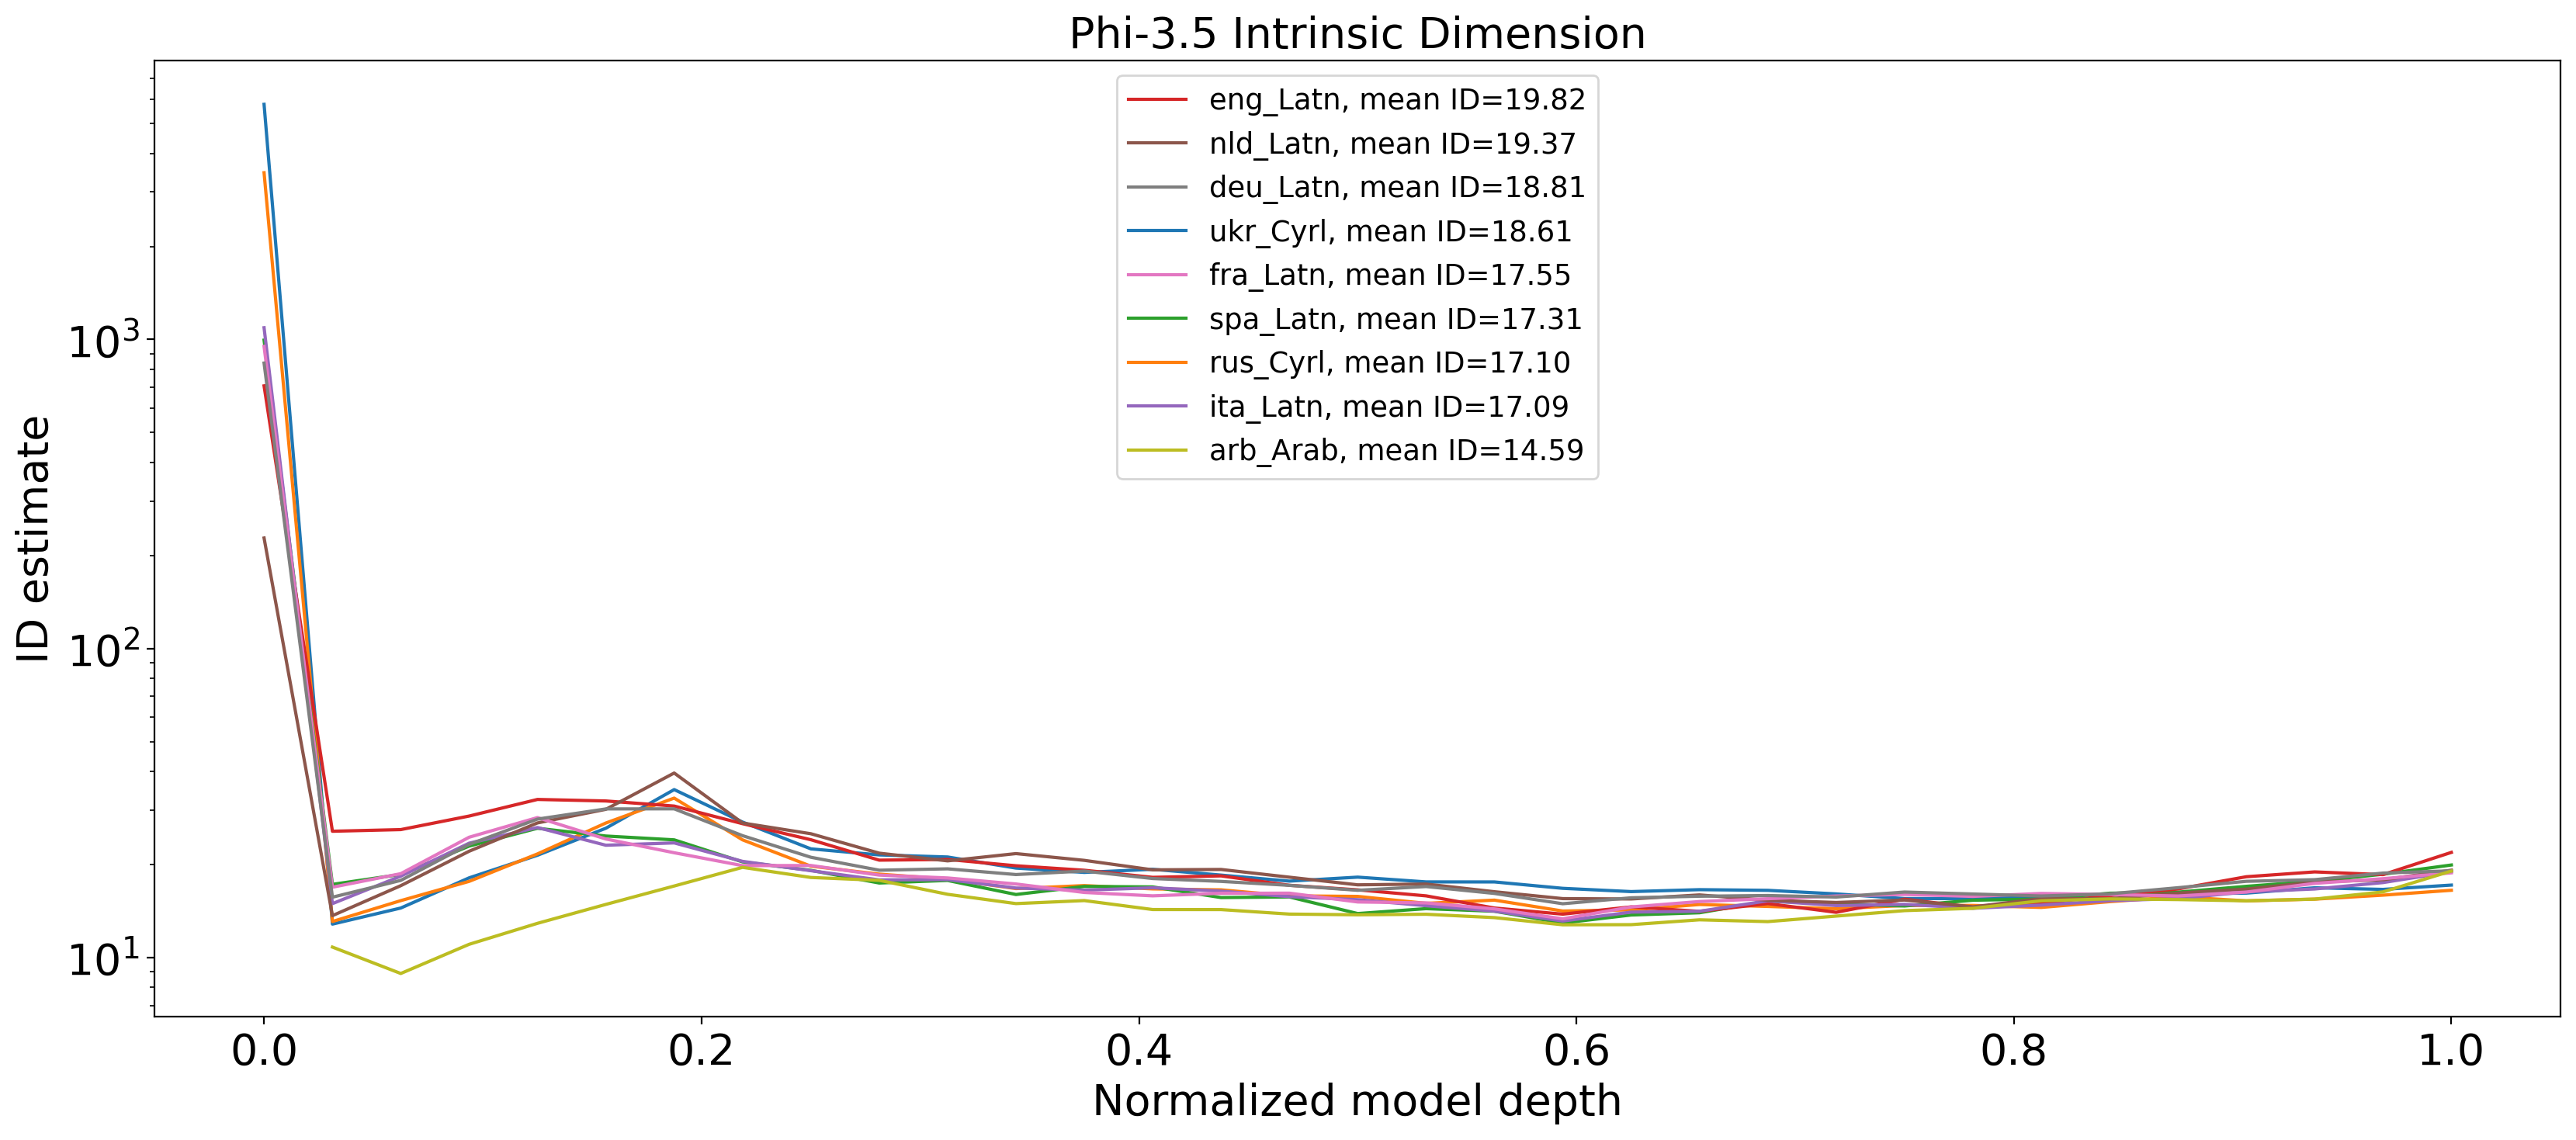

In [53]:
###############
# Print ID 

fs=20

plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Intrinsic Dimension", fontsize=fs)

mean_metric_list = []

for language, estimate in id_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean ID={mean_metric:.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("ID estimate", fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.yscale('log')
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', 
           # bbox_to_anchor=(1.1, 1), 
           fontsize=fs/3*2)
plt.show()

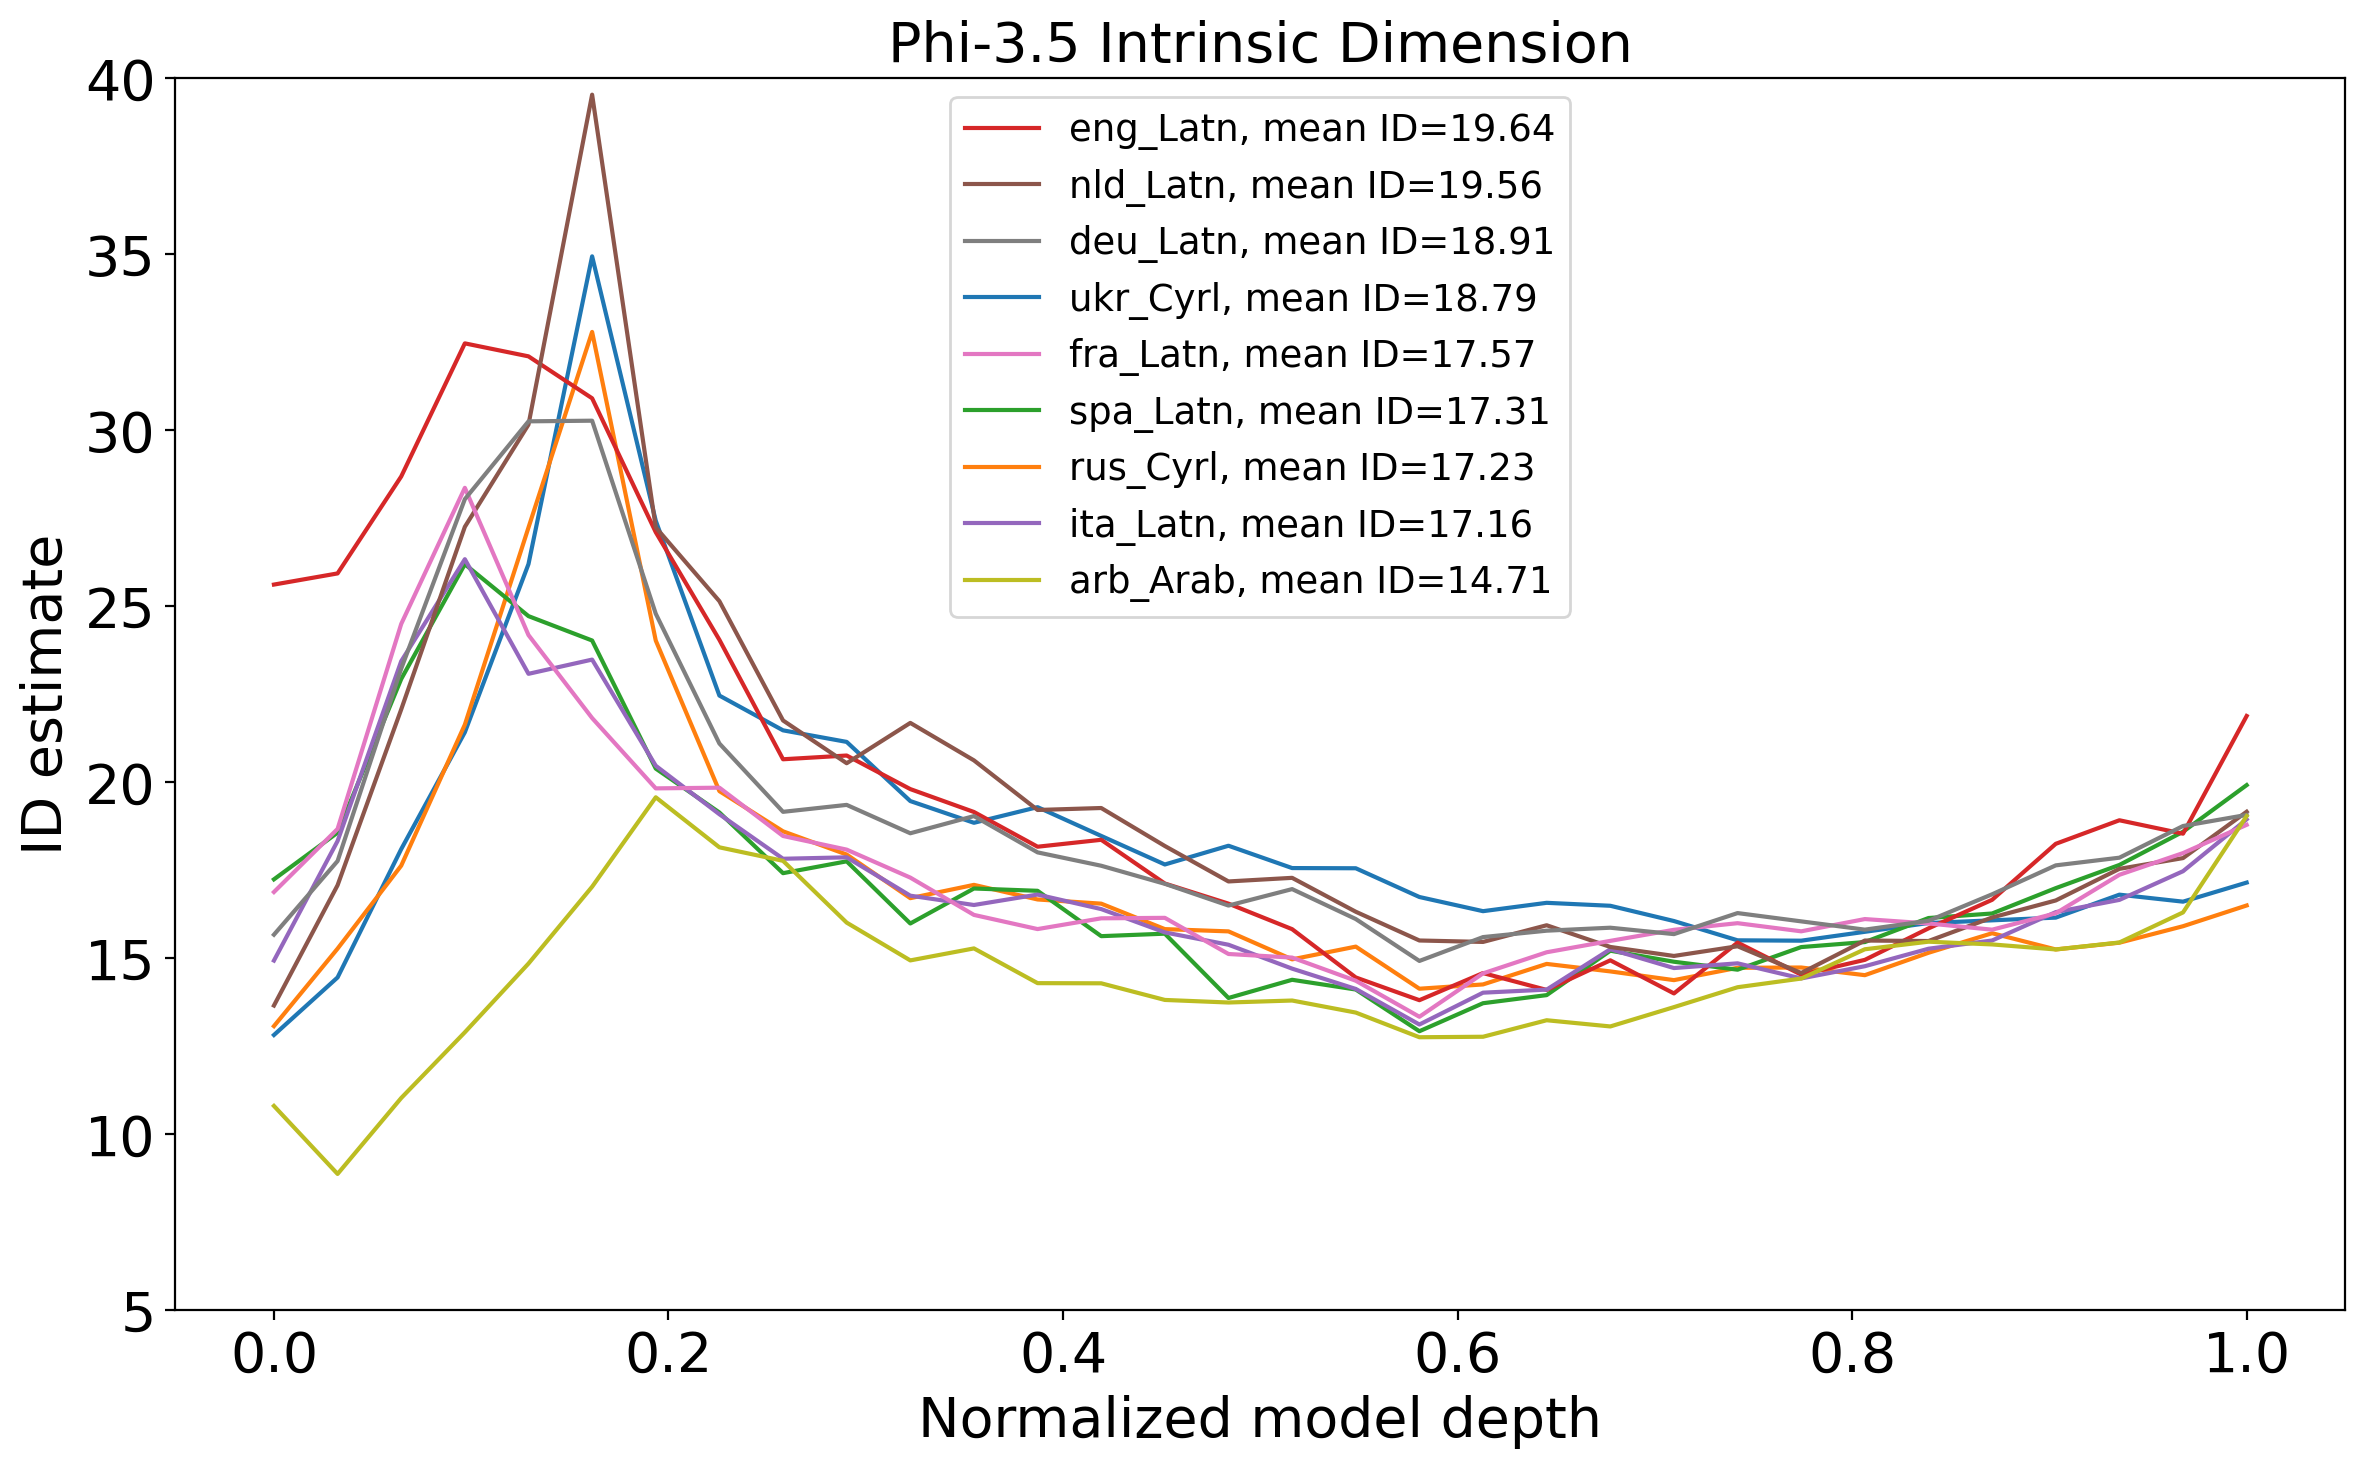

In [57]:
###############
# Print ID 

fs=20

plt.figure(figsize=(14,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Intrinsic Dimension", fontsize=fs)

mean_metric_list = []

for language, estimate in id_estimates.items():
    estimates = []
    for layer in list_layers[1:]:
        estimates.append(estimate[layer][median_sentence_id])
    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean ID={mean_metric:.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("ID estimate", fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
# plt.yscale('log')
plt.ylim(5, 40)
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', 
           # bbox_to_anchor=(1.1, 1), 
           fontsize=fs/3*2)
plt.show()

### Anisotropy

In [58]:
from collections import defaultdict
import torch
from scipy.sparse.linalg import svds
anisotropy_estimates = defaultdict(lambda: defaultdict(dict))

def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True)
    # embeddings = emb 
    num_iters = 100    
    x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype)
    for i in range(num_iters):  # критерий останова        
        x /= torch.norm(x)
        x = x @ embeddings
        x /= torch.norm(x)
        x = embeddings @ x
        # print(torch.norm(x))    
    sigma = torch.norm(x)
    anisotropy = sigma ** 2 / torch.norm(embeddings) ** 2    
    return anisotropy

idx = [k for k in hidden_states[language_en]["embed_tokens"].keys() if "_full" not in k]
idx.sort(key=int)

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        if len(sentences) != 998:
            print(f"Dropping '{language}' lang, len={len(sentences)}")
            break
            
        sentence_emb = torch.cat([sentences[i] for i in idx]).to(dtype=torch.float32, device=DEVICE)[:-1]
        anisotropy_estimate = calculate_anisotropy_torch(sentence_emb)
        # anisotropy_estimate = llm_microscope.calculate_anisotropy_torch(sentence_emb)
        anisotropy_estimates[language][layer][median_sentence_id] = anisotropy_estimate.to('cpu')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

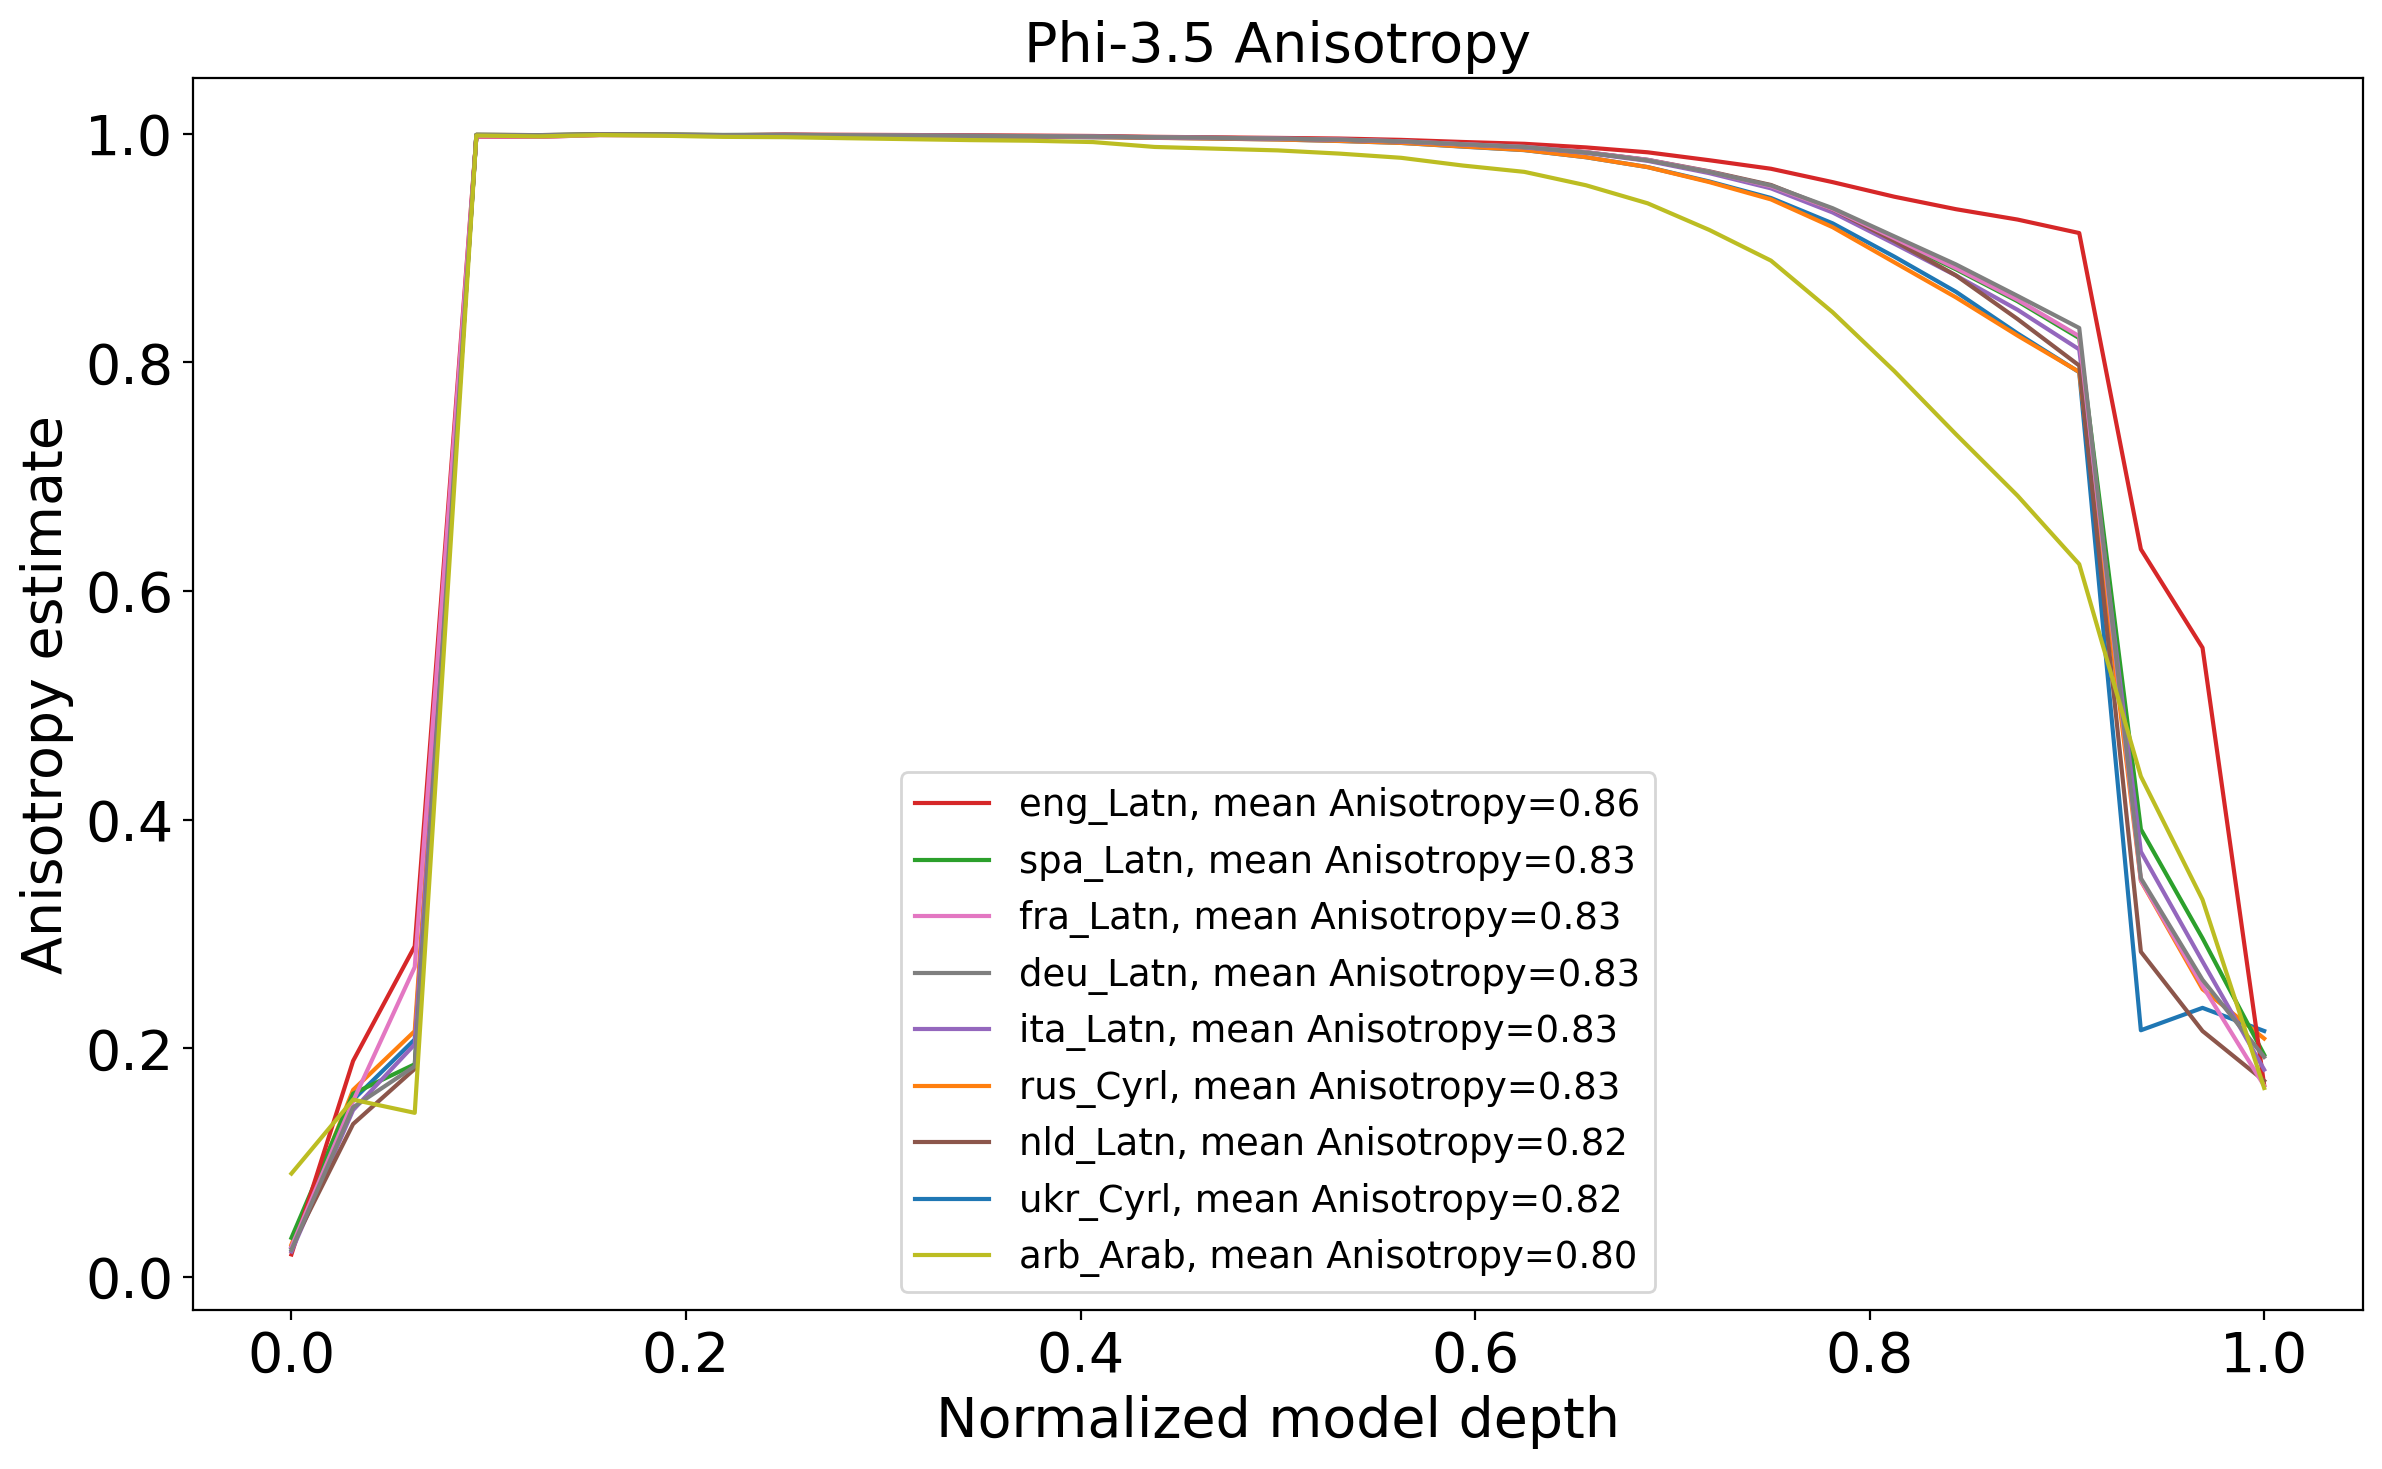

In [66]:
plt.figure(figsize=(14,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy", fontsize=fs)

mean_metric_list = []

for language, estimate in anisotropy_estimates.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])

    mean_metric = np.mean(estimates[1:])
    mean_metric_list.append(mean_metric)
    
    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean Anisotropy={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth", fontsize=fs)
plt.ylabel("Anisotropy estimate", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='lower center', 
           # bbox_to_anchor=(1.1, 1), 
           fontsize=fs/3*2)

# plt.savefig("result_folder/Figures/LR_err_dilated.png", format='png', dpi=600, bbox_inches='tight')

plt.show()


# Anisotropy with CosSim from Ethayarajh 2019

In [95]:
# embs = torch.cat(list(hidden_states[language_en]['embed_tokens'].values())).to(dtype=torch.float32, device=DEVICE)[:-1]
embs = torch.cat(list(hidden_states[language_en]['embed_tokens'].values())).to(dtype=torch.float32, device=DEVICE)

embs.shape

torch.Size([29485, 3072])

In [97]:
# check nans
embs.isnan().sum()

tensor(0, device='cuda:2')

In [255]:
num_samples = 10000

# compute cosine sim
indices = torch.randperm(len(embs))[:2*num_samples]
emb_left, emb_right = embs[indices[:num_samples]], embs[indices[num_samples: 2*num_samples]]
similarities = torch.nn.functional.cosine_similarity(emb_left, emb_right)

# Compute MEV values and compare variance
# mev_values = []
# for _ in range(100):
#     # compute MEV 
#     indices = torch.randperm(len(embs))[:num_samples]
#     mev_value = calculate_mev_torch(embs[indices])

#     mev_values.append(mev_value.item())
# plt.hist(mev_values, bins=20);

In [258]:
similarities.shape

torch.Size([10000])

MEV - 500 samples, 1000 runs
<img src="attachment:28d4c6d0-a13d-490f-a328-105f88470354.png" alt="Drawing" style="width: 500px;"/>



In [270]:
def get_cos_baseline(embs, num_samples=10_000):
    """
    Anisotropy adjustment for MEV - baseline for MEV
        "For maximum explainable variance (MEV), the baseline is the proportion of variance in \ 
        uniformly randomly sampled word representations that is explained by their first principal component"
        Sample `num_samples` pairs of words and compute cosine_sim between them
    """
    # assert 2*num_samples<=len(embs), "2*num_samples > len(embs)"
    if not 2*num_samples<=len(embs):
        num_samples = len(embs) // 2
    indices = torch.randperm(len(embs))[:2*num_samples]
    emb_left, emb_right = embs[indices[:num_samples]], embs[indices[num_samples: 2*num_samples]]
    similarities_random_words = torch.nn.functional.cosine_similarity(emb_left, emb_right)   
    return similarities_random_words

In [284]:
# Compute MEV baseline for every layer and language

anisotropy_baselines = defaultdict(lambda: defaultdict(dict))

for language, hidden_state in tqdm(hidden_states.items()):
    for layer, sentences in tqdm(hidden_state.items(), leave=False):
        # if len(sentences) != 998:
        #     print(f"Dropping '{language}' lang, len={len(sentences)}")
        #     break
            
        sentence_emb = torch.cat([sentences[i] for i in idx]).to(dtype=torch.float32, device=DEVICE)[:-1]
        anisotropy_baseline = get_cos_baseline(sentence_emb, num_samples=30_000)
        anisotropy_baselines[language][layer] = anisotropy_baseline.to('cpu')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

In [272]:
# Plot baseline anisotropy for 

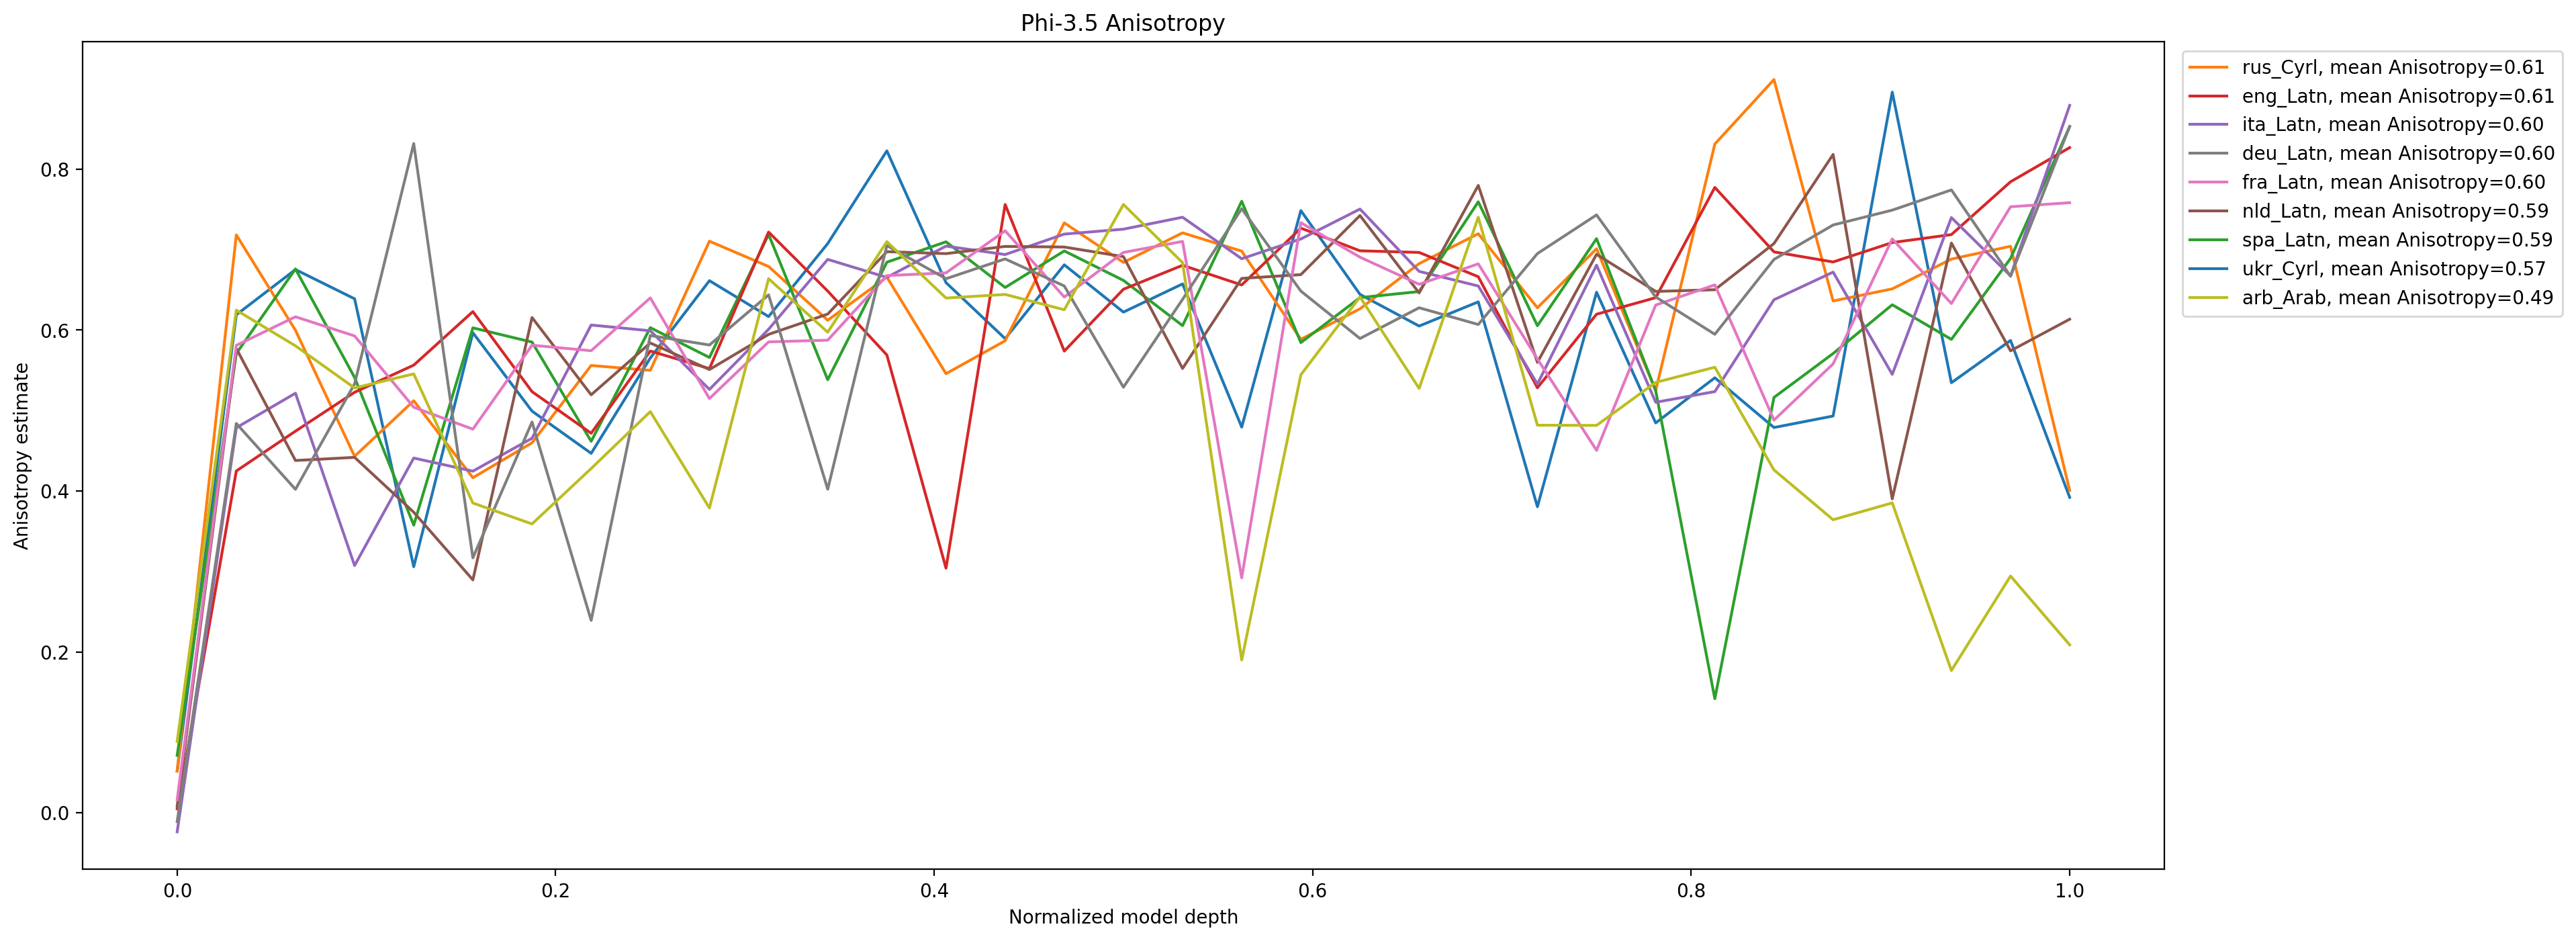

In [285]:
plt.figure(figsize=(20,8))
title = model_dir.rsplit("-", 2)[0]
plt.title(f"{title} Anisotropy")

mean_metric_list = []

for language, estimate in anisotropy_baselines.items():
    estimates = []
    for layer in list_layers:
        estimates.append(estimate[layer][median_sentence_id])

    mean_metric = np.mean(estimates[1:]) # without embedding layer
    mean_metric_list.append(mean_metric)

    plt.plot(np.linspace(0, 1, len(estimates)), estimates, label=f"{language}, mean Anisotropy={np.mean(estimates):.2f}")
plt.xlabel("Normalized model depth")
plt.ylabel("Anisotropy estimate")

idxs_sorted_metric = sorted(range(len(mean_metric_list)), key=lambda k: mean_metric_list[k], reverse=True)
handles, labels = map(np.array, plt.gca().get_legend_handles_labels())
plt.legend(handles[idxs_sorted_metric], labels[idxs_sorted_metric], loc='upper center', bbox_to_anchor=(1.1, 1))

# plt.savefig("result_folder/Figures/LR_err_dilated.png", format='png', dpi=600, bbox_inches='tight')

plt.show()

> Evaluating Anisotropy with cosine similarities requires more compute because of the necessity to use pairs of samples, not unique samples like in MEV